## Calculate the stem Contour

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import tifffile as tiff
from scipy import ndimage, stats #for median filter,extract foreground
import seaborn as sns
from unidip import UniDip # check for Unimodality
from PIL import Image
import func_get_data as fx
import pandas as pd
import shutil

## Define the path to imgs and predict tiff

In [10]:
folder_idx = 0
dingyi_cwd = os.getcwd()
disk_path = os.path.join(dingyi_cwd,'../..')
#folder_result path
process_output = os.path.join(disk_path,'Server_output/processed/v11.007_processed')
#list alll the folder in that 
all_folders_name = np.sort(os.listdir(process_output))
all_folders_dir = [os.path.join(process_output,folder) for folder in all_folders_name]
all_folders_dir_processed = [os.path.join(folder_dir, os.listdir(folder_dir)[1]) for folder_dir in all_folders_dir]
dir_path = all_folders_dir_processed[folder_idx]
folder_name = all_folders_name[folder_idx]#Alclat2_stem
#if the name is is similar to the path, we will enter to that folder no need to take care of this part yet.
img_folder = os.path.join(disk_path,'Done/Processed')
use_predict_tif = True
has_processed = True

## calculate centroid position of embolism events

In [11]:
input_tif_path = fx.get_input_tif_path(use_predict_tif,has_processed,dir_path,img_folder)
input_tiff = tiff.imread(input_tif_path)#num_imgs x row_num x col_num
input_tiff = -(input_tiff-255)
#0: background. 255:embolism
emb_img_idx_plot,emb_num_plot = fx.get_img_idx_from_tiff(input_tiff)
cc_min_area = 50#for better visualization (you can barely see cc with area < cc_min_area even if you plot them out)
cc_min_area2 = 10#is used in case there's no cc with area > cc_min_area
plot_mat_all = fx.get_pixel_pos_and_cc_from_imgs(input_tiff,emb_img_idx_plot,cc_min_area,cc_min_area2)
#calculate the centroid row and col position of our prediction result
plot_mat_all_avg = plot_mat_all.loc[:,['number_emb','cc_centroid_row','cc_centroid_col']].groupby('number_emb').max()
#reset the number of embolism to column
plot_mat_all_avg.reset_index(inplace=True)
#put the corresponding img number in dataframe
plot_mat_all_avg['emb_img_idx'] = emb_img_idx_plot
#initial inside or not, inistial it all to be True, and change to False if its not 
plot_mat_all_avg['inside_mask'] = True
#go into the current processing folder
current_raw_img_paths = os.path.join(img_folder,folder_name)
# list all the img in current processing folder
img_paths = sorted(glob.glob(current_raw_img_paths+'/*.png'))

# for each row i want to test whether this is currentlty inside the mask or not
for i in plot_mat_all_avg.index:
    #get the current img_idx 
    img_idx = plot_mat_all_avg.loc[i,'emb_img_idx']
    ##process the img stem(if its uni-modal distributed, using extract_green layer, else OTSU thresholding)
    #perform unimodality test
    current_img_path = img_paths[img_idx]
    if fx.unimodality_dip_test(current_img_path):
        imgRGB_arr=np.float32(Image.open(current_img_path))#RGB image to numpy array
        imgGarray = imgRGB_arr[:,:,1] #only look at G layer
        stem_countour = fx.extract_foregroundRGB(imgGarray)
    else:
        #read the first img
        frist_img_array = cv2.imread(first_img_path)
        #compute the stem mask ndarray
        stem_countour = fx.foregound_Th_OTSU(frist_img_array)
    #extract the corresponding centorid row and col values
    cen_row_pos = int(np.ceil(plot_mat_all_avg.loc[i,'cc_centroid_row']))
    cen_col_pos = int(np.ceil(plot_mat_all_avg.loc[i,'cc_centroid_col']))
    #check whether this centroid layer inside the countour
    plot_mat_all_avg.loc[i,'inside_mask'] = stem_countour[cen_row_pos,cen_col_pos] == 1

## For each embolism event want to figure out its inside or not and save the image of those not inside the mask

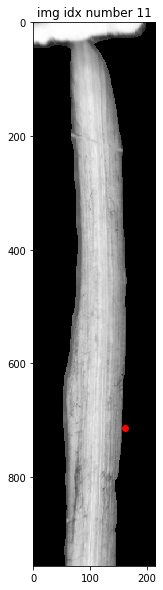

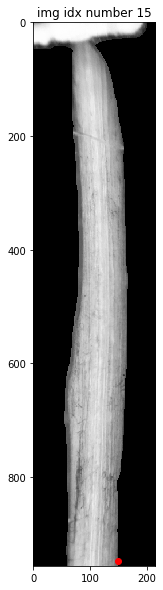

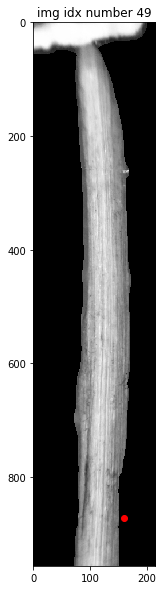

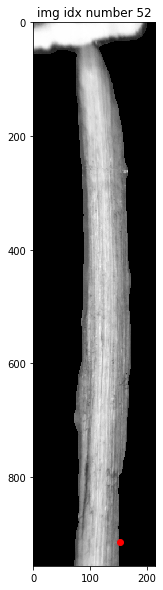

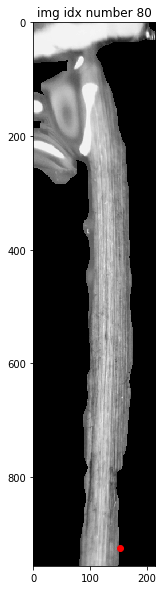

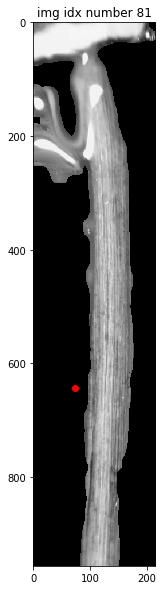

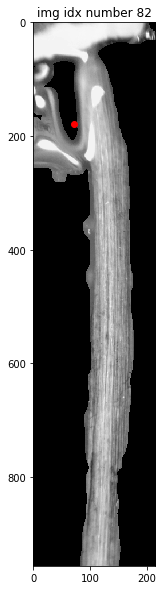

In [12]:
# for each row i want to test whether this is currentlty inside the mask or not
for i in plot_mat_all_avg.index:
    #get the current img_idx 
    img_idx = plot_mat_all_avg.loc[i,'emb_img_idx']
    ##process the img stem(if its uni-modal distributed, using extract_green layer, else OTSU thresholding)
    #perform unimodality test
    current_img_path = img_paths[img_idx]
    if fx.unimodality_dip_test(current_img_path):
        imgRGB_arr=np.float32(Image.open(current_img_path))#RGB image to numpy array
        imgGarray = imgRGB_arr[:,:,1] #only look at G layer
        stem_countour = fx.extract_foregroundRGB(imgGarray)
    else:
        #read the first img
        frist_img_array = cv2.imread(first_img_path)
        #compute the stem mask ndarray
        stem_countour = fx.foregound_Th_OTSU(frist_img_array)
    #extract the corresponding centorid row and col values
    cen_row_pos = int(np.ceil(plot_mat_all_avg.loc[i,'cc_centroid_row']))
    cen_col_pos = int(np.ceil(plot_mat_all_avg.loc[i,'cc_centroid_col']))
    #check whether this centroid layer inside the countour
    mask_bool = stem_countour[cen_row_pos,cen_col_pos] == 1
    plot_mat_all_avg.loc[i,'inside_mask'] = mask_bool
    # if it's not inside mask, want to save the photos to see whether its our mask problem
    not_inside_mask_folder = os.path.join(dir_path,'not_inside_mask')
    if not os.path.exists(not_inside_mask_folder):
        os.makedirs(not_inside_mask_folder)
    else:
        shutil.rmtree(not_inside_mask_folder)
        os.makedirs(not_inside_mask_folder)
    if mask_bool == False:
        fig,ax = plt.subplots(figsize = (5,10))
        ax.imshow(imgGarray * stem_countour,cmap = 'gray')
        ax.scatter(cen_col_pos,cen_row_pos,color = 'r')
        ax.set_title(f'img idx number {i}')
        plt.savefig(not_inside_mask_folder + '/'+ str(i) + '_not_in_img.jpg' )

## calculate the confusion metrics for seperated events

In [19]:
plot_mat_all_avg[plot_mat_all_avg['inside_mask'] == False]
#find out the real tiff in the img folders
true_tiff_path = glob.glob(current_raw_img_paths+'/*.tif')
predict_inside_idx = set(plot_mat_all_avg[plot_mat_all_avg['inside_mask'] == True]['emb_img_idx'])
#calculate the confusion mat, fp list and fn.
con_img_list = fx.confusion_mat_idx(predict_inside_idx,true_tiff_path)
metrix_img = fx.calc_metric(con_img_list[0])
with open (not_inside_mask_folder + '/confusion_mat_margin.txt','w') as f:
    f.write('img level metric:\n')
    f.write(str(metrix_img))
    f.write(str("\n\n"))
    f.write(str(con_img_list[0]))
    f.write(str("\n\n"))
    f.write(f'false positive img index: {con_img_list[1]}')
    f.write(str("\n\n"))
    f.write(f'false negative img index: {con_img_list[2]}')
    f.write(str("\n\n"))